In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]

In [6]:
## arrange data
female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]

In [7]:
# avarage per age or session
m_df= male_df.groupby(['age','uuid']).mean()
avg_m_df = male_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
avg_f_df = female_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

In [8]:
#m_data= m_data.groupby('age').mean()
f_data= f_df.groupby(['age','uuid']).mean()
m_data= m_df.groupby(['age','uuid']).mean()

In [9]:
## normalize by min/max
avg_male = mm_norm_col(m_data)
avg_female = mm_norm_col(f_data)

In [10]:
## normalize by min/max
avg_male = m_data.copy()
avg_female = f_data.copy()

In [11]:
# use only common ages
f_ages = avg_female.index.get_level_values('age').unique().to_numpy()
m_ages = avg_male.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
m_data = avg_male.loc[avg_male.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = avg_female.loc[avg_female.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])
#data.set_index('sex',inplace=True,append=True)

In [12]:
# look at syllable usage diff male and females according to actual age
diff_age_ont =m_data.groupby('age').mean().to_numpy()-f_data.groupby('age').mean().to_numpy()

In [13]:
def normalize_matrix(matrix):
    # Find the minimum and maximum values in the matrix
    min_value = np.min(matrix)
    max_value = np.max(matrix)
    
    # Normalize the matrix using the formula
    normalized_matrix = (matrix - min_value) / (max_value - min_value) * 2 - 1
    
    return normalized_matrix

new_diff_ont = normalize_matrix(diff_age_ont)

In [14]:
# plot syllable usage acoss time points
#colors for plotting
data_labels = f_data.index.get_level_values('age').unique().to_numpy()
cmap2 = cma
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

In [15]:
a=diff_age_ont.sum(axis=0)
ind = np.argsort(-a)
data=diff_age_ont.T
data=data[ind]

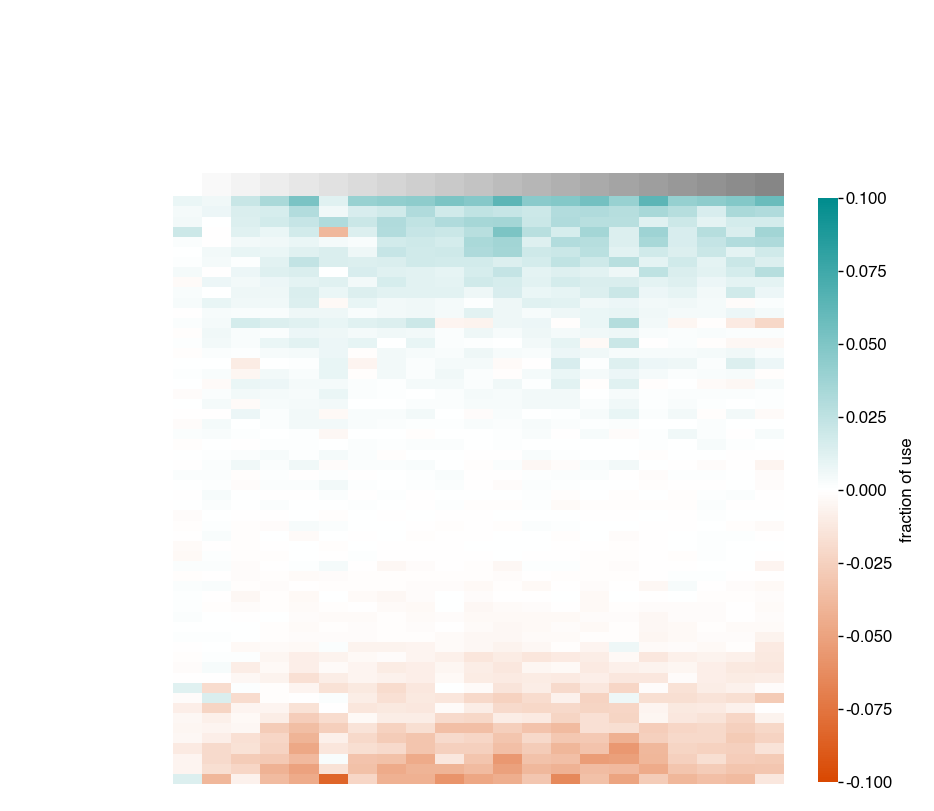

In [16]:
cg=sns.clustermap(
    data=data,
    cmap=cmmf, 
    figsize=(4, 4),
    col_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    cbar_kws={'label': 'fraction of use'}, 
    vmax=0.1,
    vmin=-0.1,
)

In [17]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig3"/ 'fvm_syll_over_time.pdf', bbox_inches='tight')